In [1]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

np.random.seed(1234)
STATE = "WI"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)



In [2]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]



I intend to audit for racial bias in employment in my home state of Wisconsin.

In [3]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [5]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train
df.head

<bound method NDFrame.head of        AGEP  SCHL  MAR  RELP  DIS  ESP  CIT  MIG  MIL  ANC  NATIVITY  DEAR  \
0      12.0   8.0  5.0   2.0  2.0  1.0  1.0  1.0  0.0  2.0       1.0   2.0   
1      61.0  16.0  1.0   0.0  2.0  0.0  1.0  1.0  4.0  2.0       1.0   2.0   
2      71.0  18.0  2.0   0.0  2.0  0.0  1.0  1.0  4.0  2.0       1.0   2.0   
3      82.0  14.0  2.0   0.0  1.0  0.0  1.0  1.0  4.0  1.0       1.0   2.0   
4      65.0  16.0  5.0  15.0  2.0  0.0  1.0  3.0  2.0  1.0       1.0   2.0   
...     ...   ...  ...   ...  ...  ...  ...  ...  ...  ...       ...   ...   
47861  75.0  21.0  5.0   0.0  2.0  0.0  1.0  1.0  3.0  1.0       1.0   2.0   
47862  27.0  19.0  5.0  13.0  1.0  0.0  1.0  1.0  4.0  1.0       1.0   1.0   
47863  42.0  13.0  3.0  13.0  2.0  0.0  1.0  1.0  4.0  4.0       1.0   2.0   
47864  50.0  21.0  5.0   0.0  2.0  0.0  1.0  1.0  4.0  1.0       1.0   2.0   
47865  80.0   7.0  5.0  16.0  1.0  0.0  1.0  1.0  4.0  4.0       1.0   2.0   

       DEYE  DREM  SEX  group  la

There are 47866 individuals in this data set.

In [6]:
df.groupby("label").size()

label
False    24318
True     23548
dtype: int64

Of these individuals, 24318 are unemployed while 23548 are employed. They are split into the following groups:
*White is 1 and Black is 2

In [7]:
df.groupby("group").size()

group
1    43637
2     1597
3      377
4        4
5       40
6      792
7       18
8      540
9      861
dtype: int64

We are focusing on white and black people in this audit. There are 43637 people who identified as white in this data set and 1597 people who identified as black.

In [8]:
df.groupby("group")["label"].mean()

group
1    0.502624
2    0.339386
3    0.387268
4    0.250000
5    0.275000
6    0.492424
7    0.333333
8    0.485185
9    0.298490
Name: label, dtype: float64

In this data, 50.2% of white people were employed, while 33.9% of black people were employed

We can also look at sex, and see how the intersection of these two impcact employment.

In [9]:
race_and_sex = []
for x in range (47866):
    if df.loc[x,"group"]==1 and df.loc[x,"SEX"]==1:
       race_and_sex.append("White Male")
    elif df.loc[x,"group"]==1 and df.loc[x,"SEX"]==2:
        race_and_sex.append("White Female")
    elif (df.loc[x,"group"]==2 and df.loc[x,"SEX"]==1):
        race_and_sex.append("Black Male")
    elif(df.loc[x,"group"]==2 and df.loc[x,"SEX"])==2:
        race_and_sex.append("Black Female")
    else:
        race_and_sex.append("Other")
        
df.insert(1, "RAS", race_and_sex)        


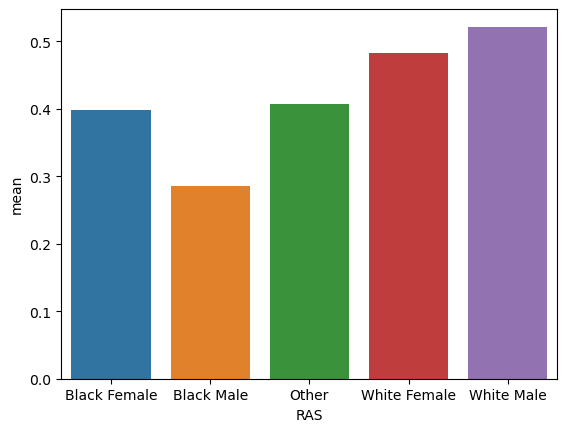

In [10]:
import seaborn as sns

means = df.groupby(["RAS"])["label"].mean().reset_index(name = "mean")
p = sns.barplot(data = means, x = "RAS", y = "mean")



From this, we can see that white males slightly outpace white females, with both being more employed than any other groups. Black females are slightly behind white females, but the big drop is with black males, of whom less than 30% where employed.

In [11]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

X_train_val = X_train[43000:]
y_train_val = y_train[43000:]
X_train = X_train[:43000]
y_train =y_train[:43000]

Before we create our model, we can try to tune it, using optional parameters and cross validation. We are tuning the C value of the SVC model, which tweaks how the model determines a hyperplane, with a large C value focusing on properly classifying the most pieces of data, and a low value of C focusing on a hyperplane that has the largest margin between it and the pieces of data, ie, as close to halfway between the sets of points.

In [12]:

scores =[]
for i in range (10):
    model = make_pipeline(StandardScaler(), SVC(C=i+1))
    model.fit(X_train, y_train)
    scores.append(model.score(X_train_val, y_train_val))

    

In [13]:
scores

[0.8425811755034937,
 0.8419646526921496,
 0.8413481298808055,
 0.8417591450883682,
 0.8417591450883682,
 0.842170160295931,
 0.8415536374845869,
 0.842170160295931,
 0.8415536374845869,
 0.8401150842581175]

When we tune our model, we see that our tuning does very little, but that we get the highest scores with a C value of 6.

In [19]:
model = make_pipeline(StandardScaler(), SVC(C=6))
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8439040695245258

The model has an overall accuracy of 84.39%.

In [15]:
g1 =[]
g2 =[]
for i in range (11967):
    if df.loc[i,"group"] == 1:
        g1.append(i)
    elif df.loc[i, "group"]==2:
        g2.append(i)

from sklearn.metrics import confusion_matrix



In [16]:
y_hat =model.predict(X_test[g1])
g1Matrix = confusion_matrix (y_hat, y_test[g1])
g1PPV = g1Matrix[0][0]/(g1Matrix[0][0]+g1Matrix[1][0])
g1FNR = g1Matrix[1][0]/(g1Matrix[1][0]+g1Matrix[0][0])
g1FPR = g1Matrix[0][1]/(g1Matrix[1][1]+g1Matrix[0][1])
(y_hat == y_test[g1]).mean()
g1Matrix

array([[4494,  653],
       [1067, 4683]])

It has an accuracy of 84.2% for white individuals and 83.9% for black individuals.

In [17]:
y_hat =model.predict(X_test[g2])
g2Matrix = confusion_matrix(y_hat, y_test[g2])
g2PPV = g2Matrix[0][0]/(g2Matrix[0][0]+g2Matrix[1][0])
g2FNR = g2Matrix[1][0]/(g2Matrix[1][0]+g2Matrix[0][0])
g2FPR = g2Matrix[0][1]/(g2Matrix[1][1]+g2Matrix[0][1])
(y_hat == y_test[g2]).mean()
g2Matrix

array([[174,  23],
       [ 43, 171]])

The model gives the following PPV, FNR and FPR rates:

In [18]:
print("The PPV for white individuals is : ",g1PPV)
print("The FNR for white individuals is : ",g1FNR)
print("The FPR for white individuals is : ",g1FPR)
print("The PPV for black individuals is : ",g2PPV)
print("The FNR for black individuals is : ",g2FNR)
print("The FPR for black individuals is : ",g2FPR)



The PPV for white individuals is :  0.8081280345261643
The FNR for white individuals is :  0.19187196547383564
The FPR for white individuals is :  0.12237631184407796
The PPV for black individuals is :  0.8018433179723502
The FNR for black individuals is :  0.19815668202764977
The FPR for black individuals is :  0.11855670103092783


This model is calibrated because it doesn't take into account race, and so given a piece of data, the same score would be returned regardless of which group the individual belonged to. This model also satisfies error rate balance, as the false positive and true negative rates are almost identical across our two groups. This model does not satisfy statistical parity, however, as it predicts that 75% of white people are employed while only predicting 47% of black people are employed.

The people who benefit from this algorithm are likely companies that are trying to ascertain interest rates to give on loans or whether or not to give them out at all. While these companies would most likely ask for current employment, they could use this model to predict how likely a person is to remain employed and adjust their decisions accordingly. If this model were to be released and used for this purpose, based on my audit, black individuals would be harmed as they would recieve higher interest rates if they were even granted loans in the first place. Based on my audit, I think that the model displays some bias, which can be seen in the lack of statistical parity. This bias is a a result of a bias in the data itself, which we saw when we looked at the data. This bias worries me, as I fear this model would be used as a way to discriminate while pretending to be fair because it is calibrated and has good error rate balance, but doens't have the context of redlining and discrimination that go into the features it is trained on. Besides the Bias issues inherent in this model, I don't have any big objections with deploying this model.